In [49]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


## Loading the data

In [50]:
train_data = pd.read_csv("forest-3-a-2024/train.csv")


In [51]:
train_data.shape

(15120, 56)

In [52]:
# train_data.head()

In [53]:
# train_data.iloc[:,40:50].describe()

In [54]:
#train_data.isnull().sum()

In [55]:
#check for string type columns
string_columns = train_data.select_dtypes(include=['object']).columns
print("Columns with string values:", string_columns)


Columns with string values: Index([], dtype='object')


In [56]:
data = train_data.drop('Id', axis=1)

In [57]:
# fine the coorilation between the features
# corelation_matrix = train_data.corr()
# # draw the heatmap
# heatmap = sns.heatmap(corelation_matrix, annot=True)
# plt.show()
# print(corelation_matrix)

## Feature Engineering And Selection

In [58]:
import featuretools as ft

### 1. Grouping feature

In [59]:
# Group of Wilderness_Area
wilderness_area = train_data.loc[:,'Wilderness_Area1':'Wilderness_Area4']
#print(wilderness_area)

# Group of Soil_Type
soil_type = train_data.loc[:,'Soil_Type1':'Soil_Type40']
#print(soil_type)

# Group of Continuous Features
continuous_features = train_data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']

#### 1.1 Analysis the corelation between wilderness Area and covertype

In [60]:
# corr_matrix = wilderness_area.corr()
# print(corr_matrix)
# heatmap = sns.heatmap(corr_matrix, annot=True)
# plt.show()

### 2. Continue variable feature engineering

Now, we extract the feature from the continue variable by adding the new feature such summation between two feature, substraction between two feature and multiplication between two feature.

In [61]:

def continuous_features_extraction(X):
    # Create EntitySet
    es = ft.EntitySet(id='Cover_Type')

    # Add the input DataFrame as an entity
    es = es.add_dataframe(
        dataframe_name='X',
        dataframe=X.iloc[:, :10],  # Corrected from oloc to iloc
        make_index=True,
        index='Index'  # Corrected typo 'Idex' to 'Index'
    )

    # Run deep feature synthesis with transformation primitives
    new_features, feature_defs = ft.dfs(
        entityset=es,
        target_dataframe_name='X',
        trans_primitives=['add_numeric', 'multiply_numeric', 'subtract_numeric'],
        max_depth=1
    )
    print(feature_defs)

    # Combine the new features with the original DataFrame
    updated_X = pd.concat([X, new_features], axis=1)
    # Removing duplicate columns by comparing columns in the original dataframe with new_features
    duplicates = updated_X.columns.duplicated(keep='first')
    updated_X = updated_X.loc[:, ~duplicates]

    return updated_X


In [62]:
data = continuous_features_extraction(data)

[<Feature: Elevation>, <Feature: Aspect>, <Feature: Slope>, <Feature: Horizontal_Distance_To_Hydrology>, <Feature: Vertical_Distance_To_Hydrology>, <Feature: Horizontal_Distance_To_Roadways>, <Feature: Hillshade_9am>, <Feature: Hillshade_Noon>, <Feature: Hillshade_3pm>, <Feature: Horizontal_Distance_To_Fire_Points>, <Feature: Aspect + Elevation>, <Feature: Aspect + Hillshade_3pm>, <Feature: Aspect + Hillshade_9am>, <Feature: Aspect + Hillshade_Noon>, <Feature: Aspect + Horizontal_Distance_To_Fire_Points>, <Feature: Aspect + Horizontal_Distance_To_Hydrology>, <Feature: Aspect + Horizontal_Distance_To_Roadways>, <Feature: Aspect + Slope>, <Feature: Aspect + Vertical_Distance_To_Hydrology>, <Feature: Elevation + Hillshade_3pm>, <Feature: Elevation + Hillshade_9am>, <Feature: Elevation + Hillshade_Noon>, <Feature: Elevation + Horizontal_Distance_To_Fire_Points>, <Feature: Elevation + Horizontal_Distance_To_Hydrology>, <Feature: Elevation + Horizontal_Distance_To_Roadways>, <Feature: Elevat

### 2. Categorical Encoding

Soil Types: 1 to 40 : based on the USFS Ecological Landtype Units (ELUs) for this study area, where the ELU is comprised of four digits:

   1) First digit: climatic zone
   
   2) Second digit: geologic zones
   
So here, intuitively we can extract two new features from the soil_type  which are:

   - 'climatic zone'
   
   - 'geologic zone' 

In [63]:
# Mapping soil type to ELU code
ELU_CODE = {
    1:2702,2:2703,3:2704,4:2705,5:2706,6:2717,7:3501,8:3502,9:4201,
    10:4703,11:4704,12:4744,13:4758,14:5101,15:5151,16:6101,17:6102,
    18:6731,19:7101,20:7102,21:7103,22:7201,23:7202,24:7700,25:7701,
    26:7702,27:7709,28:7710,29:7745,30:7746,31:7755,32:7756,33:7757,
    34:7790,35:8703,36:8707,37:8708,38:8771,39:8772,40:8776
}

To improve one the performence of model in the classical midel like tree-based model, it works better without one-hot encodind, so we extract soil type by reverse one-hot encoding.We will enventually drop the original soil type columns which has the added effect of significantly reducing the total number of feature.

In [64]:
def categorical_encoding(data):
    data = data.copy()
    data['Soil_Type'] = 0
    for i in range(1, 41):
        data['Soil_Type'] += i * data['Soil_Type' + str(i)]
    return data

In [65]:
data = categorical_encoding(data)

### 3. Climatic Zone

We now create a feature based on the climatic zone of the soil. To reach this, we determine the climatic zon by the first digit of the ELU code. The climatic zone determined by a natural ordering as follow:

1. lower montane dry
2. lower montane
3. montane dry
4. montane
5. montane dry and montane
6. montane and subalpine
7. subalpine
8. alpine

In [66]:
def climatical_zone(df):
    df = df.copy()
    df['Climatic_Zone'] = df['Soil_Type'].apply(lambda x: int(str(ELU_CODE[x])[0]))
    return df

In [67]:
data = climatical_zone(data)

### 4. Geologic Zone

Now the we extract a new feaature call geological_zone from the soil type, determined by the second digit in the ELU code. Here is the natural order of geologic zone:

1. alluvium
2. glacial
3. shale
4. sandstone
5. mixed sedimentary
6. unspecified in the USFS ELU Survey
7. igneous and metamorphic
8. volcanic

In [68]:
def geologic_zone(df):
    df = df.copy()
    df['Geologic_Zone'] = df['Soil_Type'].apply(lambda x: int(str(ELU_CODE[x])[1]))
    return df

In [69]:
data = geologic_zone(data)

### 5. Surface cover

We can also extract the surface cover from the ELUs code because on top of the ELUs code, each soil_type has their description. For example, 1: ELU 2702, Cathedral family - Rock outcrop complex, extremely stony. We can see that it gives information about the type of surface that cover that area:

1. stony
2. very stony
3. extremely stony
4. rubbly
5. no_description (no_desc)


In [70]:
def surface_cover(data):
    # from ELU code from the soil type
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stony = [6,12]
    very_stony = [2,9,18,26]
    extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
    rubbly = [3,4,5,10,11,13]
    
    # Create dictionary to your the type of surface
    surface_cover = {i:0 for i in no_desc}
    surface_cover.update({i:1 for i in stony})
    surface_cover.update({i:2 for i in very_stony})
    surface_cover.update({i:3 for i in extremely_stony})
    surface_cover.update({i:4 for i in rubbly})
    
    # Create Feature
    df = data.copy()
    df['Surface_Cover'] = data['Soil_Type'].apply(
        lambda x: surface_cover[x]
    )
    return df

In [71]:
data = surface_cover(data)

On top of surface cover, we can also extract the type of rock by combining the last two components of the description of 'soil_type'.

In [72]:
def rock_type(data):
    # Group IDs
    no_desc = [7,8,14,15,16,17,19,20,21,23,35]
    stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
    boulders = [22]
    rubble = [3,4,5,10,11,13]

    # Create dictionary
    rock_size = {i:0 for i in no_desc}
    rock_size.update({i:1 for i in stones})
    rock_size.update({i:2 for i in boulders})
    rock_size.update({i:3 for i in rubble})
    
    df = data.copy()
    df['Rock_Size'] = df['Soil_Type'].apply(
        lambda x: rock_size[x]
    )
    return data

In [73]:
data = rock_type(data)

**Wilderness Areas:**

   1) Rawah Wilderness Area

   2) Neota Wilderness Area

   3) Comanche Peak Wilderness Area
    
   4) Cache la Poudre Wilderness Area

   So, by doing linear combination between 'Wilderness_Area' and 'Climatic_Zone','Rock_Size','Surface_Cover', we can get new features that can possibly capture non-linear relatinships between features and the target variable.

In [74]:
def non_linear_relationship(data):
    df = data.copy()
    #  New Feature
    df['Climate_Area1'] = df['Wilderness_Area1']*df['Climatic_Zone'] 
    df['Climate_Area2'] = df['Wilderness_Area2']*df['Climatic_Zone'] 
    df['Climate_Area3'] = df['Wilderness_Area3']*df['Climatic_Zone'] 
    df['Climate_Area4'] = df['Wilderness_Area4']*df['Climatic_Zone'] 
    df['Rock_Area1'] = df['Wilderness_Area1']*df['Rock_Size']
    df['Rock_Area2'] = df['Wilderness_Area2']*df['Rock_Size']    
    df['Rock_Area3'] = df['Wilderness_Area3']*df['Rock_Size']  
    df['Rock_Area4'] = df['Wilderness_Area4']*df['Rock_Size']    
    df['Surface_Area1'] = df['Wilderness_Area1']*df['Surface_Cover'] 
    df['Surface_Area2'] = df['Wilderness_Area2']*df['Surface_Cover'] 
    df['Surface_Area3'] = df['Wilderness_Area3']*df['Surface_Cover'] 
    df['Surface_Area4'] = df['Wilderness_Area4']*df['Surface_Cover'] 
    
    return df

In [76]:
#data = non_linear_relationship(data)

## Dimensional Reduction

In [77]:
# Selecting the features
X = data.drop('Cover_Type', axis=1)

# Create a standard scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform
X_scale = scaler.fit_transform(X)


# Create a PCA object
pca = PCA(n_components=0.95)
pca.fit(X_scale)

# Transform the scaled features
X_pca = pca.transform(X_scale)


## Train the model

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [79]:
# Split the data into train and test
y = train_data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [80]:
def train_evaluation_model(X_train, y_train, X_test, y_test, n_fold, model):
    # Fit the model
    model.fit(X_train, y_train)
    
    # test the model with the trainning data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print('Training data accuracy:', train_accuracy)
    
    # test the model with the test data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Testing data accuracy:', test_accuracy)
    
    # evaluate the model using cross validation
    X_cross = np.concatenate((X_train, X_test), axis=0)
    y_cross = np.concatenate((y_train, y_test), axis=0)
    cross_val = cross_val_score(model, X_cross, y_cross, cv=n_fold)
    print('Cross Validation:', cross_val)	
    print('Cross Validation Mean:', cross_val.mean())
    
    return y_test_pred, model

In [82]:
def train_test_all_model(X_train, y_train, X_test, y_test, n_fold):
    # Define models
    models = [
        ("LogisticRegression", LogisticRegression(max_iter=1000, multi_class='multinomial')),
        ("KNeighborsClassifier", KNeighborsClassifier()),
        ("GaussianNB", GaussianNB()),
        ("SVC", SVC()),
        ("DecisionTreeClassifier", DecisionTreeClassifier()),
        ("RandomForestClassifier", RandomForestClassifier()),
        ("ExtraTreesClassifier", ExtraTreesClassifier()),
        ("GradientBoostingClassifier", GradientBoostingClassifier()),
        ("LGBMClassifier", LGBMClassifier(objective='multiclass')),
        ("XGBClassifier", XGBClassifier(objective='multi:softmax', num_class=7))
    ]

    # Store results
    results = []

    for name, model in models:
        print(f"Training {name}...")

        # Adjust labels for XGBClassifier
        if isinstance(model, XGBClassifier):
            y_train_adjusted = y_train - 1  # Convert to 0-based indexing
            y_test_adjusted = y_test - 1
            # Train and evaluate
            model.fit(X_train, y_train_adjusted)
            y_pred = model.predict(X_test) + 1  # Restore original labels
            y_train_pred = model.predict(X_train) + 1
        else:
            # Train and evaluate for other models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Cross-validation
        if isinstance(model, XGBClassifier):
            cv_scores = cross_val_score(model, X_train, y_train_adjusted, cv=n_fold, scoring='accuracy')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=n_fold, scoring='accuracy')

        print(f"{name} - Training Accuracy: {train_accuracy}")
        print(f"{name} - Test Accuracy: {test_accuracy}")
        print(f"{name} - Cross Validation Scores: {cv_scores}")
        print(f"{name} - Cross Validation Mean Accuracy: {cv_scores.mean()}")

        # Append results
        results.append({
            "model": name,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "cv_scores": list(cv_scores),
            "cv_mean_accuracy": cv_scores.mean()
        })

        print('------------------------------------')

    return results


### Models Used in the Comparison
Here is a list of models that we use to compare for our project:

1. Logistic Regression

2. K-Nearest Neighbors (KNN)

3. Gaussian Naive Bayes

4. Support Vector Classifier (SVC)

5. Decision Tree Classifier

6. Random Forest Classifier

7. Extra Trees Classifier

8. Gradient Boosting Classifier

9. LightGBM (LGBMClassifier)

11. XGBoost Classifier
   

In [83]:
results_scaled_data_pca = train_test_all_model(X_train, y_train, X_test, y_test, 5)

Training LogisticRegression...


c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWar

LogisticRegression - Training Accuracy: 0.7062665343915344
LogisticRegression - Test Accuracy: 0.7159391534391535
LogisticRegression - Cross Validation Scores: [0.69628099 0.70855726 0.69532865 0.69739562 0.69739562]
LogisticRegression - Cross Validation Mean Accuracy: 0.6989916262098607
------------------------------------
Training KNeighborsClassifier...
KNeighborsClassifier - Training Accuracy: 0.8680555555555556
KNeighborsClassifier - Test Accuracy: 0.7943121693121693
KNeighborsClassifier - Cross Validation Scores: [0.79256198 0.79371641 0.7738735  0.7809012  0.78627532]
KNeighborsClassifier - Cross Validation Mean Accuracy: 0.7854656831762322
------------------------------------
Training GaussianNB...
GaussianNB - Training Accuracy: 0.4228670634920635
GaussianNB - Test Accuracy: 0.41798941798941797
GaussianNB - Cross Validation Scores: [0.40991736 0.4175279  0.44853245 0.42000827 0.42538239]
GaussianNB - Cross Validation Mean Accuracy: 0.42427367363742274
-------------------------

Now let compare the result for our scaling dataset with dimensional reduction using PAC.

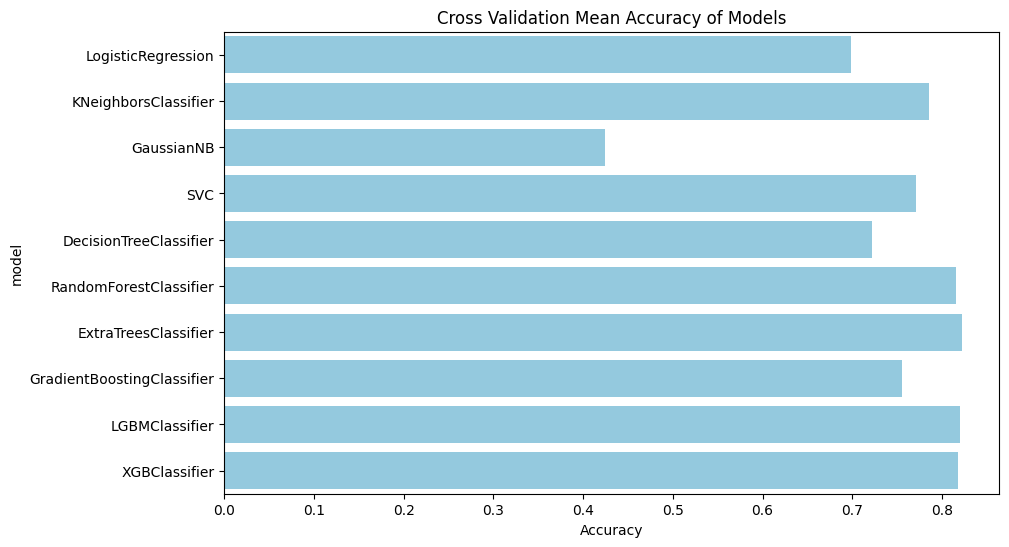

,model,train_accuracy,test_accuracy,cv_scores,cv_mean_accuracy
0,LogisticRegression,0.706267,0.715939,"[0.6962809917355371, 0.7085572550640761, 0.695...",0.698992
1,KNeighborsClassifier,0.868056,0.794312,"[0.7925619834710744, 0.7937164117403885, 0.773...",0.785466
2,GaussianNB,0.422867,0.417989,"[0.4099173553719008, 0.41752790409260027, 0.44...",0.424274
3,SVC,0.803654,0.788360,"[0.7739669421487604, 0.7705663497312939, 0.763...",0.770833
4,DecisionTreeClassifier,1.000000,0.726521,"[0.7301652892561984, 0.7288135593220338, 0.702...",0.721808
5,RandomForestClassifier,1.000000,0.833664,"[0.8272727272727273, 0.812319140140554, 0.8032...",0.815475
6,ExtraTreesClassifier,1.000000,0.834325,"[0.8318181818181818, 0.8205870194295163, 0.814...",0.822503
7,GradientBoostingClassifier,0.842510,0.768519,"[0.7524793388429752, 0.7461761058288549, 0.751...",0.755705
8,LGBMClassifier,0.995205,0.832341,"[0.8260330578512397, 0.8226539892517569, 0.807...",0.820188
9,XGBClassifier,0.999421,0.830357,"[0.8231404958677686, 0.8243075651095494, 0.804...",0.817543


In [84]:
# Plot results
def plot_results(results):
    # Create a DataFrame
    df = pd.DataFrame(results)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='cv_mean_accuracy', y='model', color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Cross Validation Mean Accuracy of Models')
    plt.show()

    return df
plot_results(results_scaled_data_pca)

Here it is hard to find the choose the model because one of them gave almost the same accuracy, especailly the tree base model.

So now I want to check what happen if we don't scale our data and don't use PCA

In [85]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
results_non_scaled_data = train_test_all_model(X_train_new, y_train_new, X_test_new, y_test_new, 5)

Training LogisticRegression...


c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ASUS\anaconda3\envs\inf554\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 

LogisticRegression - Training Accuracy: 0.642526455026455
LogisticRegression - Test Accuracy: 0.6349206349206349
LogisticRegression - Cross Validation Scores: [0.63512397 0.6300124  0.63331955 0.63869368 0.61430343]
LogisticRegression - Cross Validation Mean Accuracy: 0.6302906057075699
------------------------------------
Training KNeighborsClassifier...
KNeighborsClassifier - Training Accuracy: 0.8527612433862434
KNeighborsClassifier - Test Accuracy: 0.7533068783068783
KNeighborsClassifier - Cross Validation Scores: [0.73636364 0.74534932 0.7399752  0.74576271 0.73377429]
KNeighborsClassifier - Cross Validation Mean Accuracy: 0.7402450298771093
------------------------------------
Training GaussianNB...
GaussianNB - Training Accuracy: 0.5243882275132276
GaussianNB - Test Accuracy: 0.5125661375661376
GaussianNB - Cross Validation Scores: [0.52809917 0.51632906 0.52004961 0.51922282 0.53327821]
GaussianNB - Cross Validation Mean Accuracy: 0.523395775182013
-----------------------------

Now let compare the result of both case of dataset

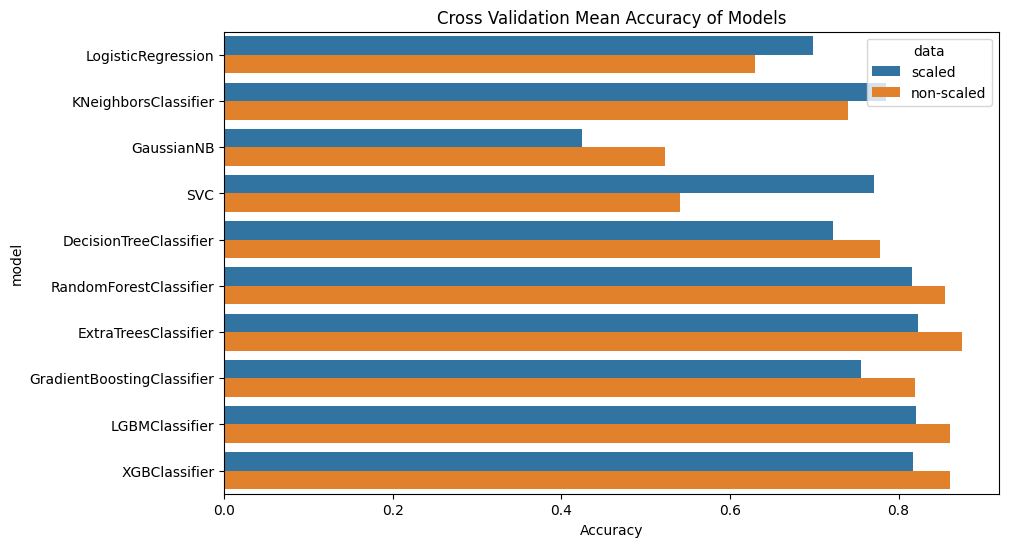

In [88]:
# Plot results of both scaled and non-scaled data
def compare_results(results1, results2):
    # Create DataFrames
    df1 = pd.DataFrame(results1)
    df1['data'] = 'scaled'
    df2 = pd.DataFrame(results2)
    df2['data'] = 'non-scaled'
    df = pd.concat([df1, df2])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='cv_mean_accuracy', y='model', hue='data')
    plt.xlabel('Accuracy')
    plt.title('Cross Validation Mean Accuracy of Models')
    plt.show()

compare_results(results_scaled_data_pca, results_non_scaled_data)

### Result

Based on the results, we observe that some models perform better with the non-scaled dataset than with the scaled dataset, even when combined with dimensionality reduction using PCA. However, we also see that the **ExtraTreesClassifier** consistently delivers the highest accuracy among all the models tested.

The reasons are as follows:

1. **Scaling-Sensitive Models:**
   - **Logistic Regression, KNN, and SVM** are sensitive to data scaling because:
     - **KNN** relies on distance metrics (e.g., Euclidean distance), where features with larger scales can dominate.
     - **Logistic Regression** and **SVM** use optimization techniques that perform better when features are scaled uniformly. 
   - Scaling ensures that all features contribute equally during training, which improves the performance of these models.

2. **Tree-Based Models:**
   - The other models used (e.g., **Random Forest, Extra Trees, Gradient Boosting, LightGBM, XGBoost**) are based on decision tree algorithms. 
   - **Tree-based models** are inherently scale-invariant because splitting criteria depend only on the relative order of feature values. As a result, the feature magnitudes or ranges do not affect their performance.

3. **Gaussian Naive Bayes:**
   - **Gaussian Naive Bayes** computes probabilities assuming feature independence and uses a Gaussian distribution for calculations. Feature scaling has little or no impact on its performance, as it does not rely on feature magnitudes or distances.


> **Model Choice**:
>
> We will choose ExtraTreeClassifier as our final model and we will improve it by doing explore more on data preprocessing and perform hyperparameter tunning.

## Perform Hyperparameeter Tuning on the best model

Most methods in tree-based models come with default parameters. However, these defaults are not necessarily optimal. While a model with default parameters may perform well on the training set, it might be too complex or lead to overfitting when applied to the overall dataset. To mitigate or avoid overfitting, hyperparameter tuning is essential. Moreover, it is one of the easiest ways to achieve a well-optimized set of hyperparameters.

There are two common methods for hyperparameter tuning: **RandomizedSearchCV** and **GridSearchCV**.

In this case, I chose to use **GridSearchCV** because the **ExtraTreesClassifier** has good performance in terms of execution time, allowing me to train all combinations of parameters efficiently.


In [ ]:
# from sklearn.model_selection import GridSearchCV
# para_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None,10, 20, 30, ],	
#     'min_samples_split': [2, 3, 5, 7, 9],
#     'min_samples_leaf': [1, 2, 4, 6, 8]
# }

# best_model = ExtraTreesClassifier()
# grid_search = GridSearchCV(best_model, param_grid = para_grid, cv = 5, scoring = 'accuracy', verbose = 1,
#                                n_jobs = -1, return_train_score = True)
# grid_search.fit(X_train_new, y_train_new)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


KeyboardInterrupt: 

In [ ]:
best_params = grid_search.best_params_
# best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
print(best_params)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}


Now train and test our model with `best_params`

In [103]:
best_model_final = ExtraTreesClassifier(**best_params)
y_test_pred, model_train = train_evaluation_model(X_train_new, y_train_new, X_test_new, y_test_new, 5, best_model_final)

Training data accuracy: 1.0
Testing data accuracy: 0.892526455026455
Cross Validation: [0.89153439 0.89186508 0.88921958 0.88227513 0.89550265]
Cross Validation Mean: 0.890079365079365


In [118]:
best_model_final = GradientBoostingClassifier()
y_test_pred, model_train = train_evaluation_model(X_train_new, y_train_new, X_test_new, y_test_new, 5, best_model_final)

Training data accuracy: 0.8856646825396826
Testing data accuracy: 0.8336640211640212
Cross Validation: [0.82638889 0.82043651 0.83068783 0.82308201 0.83796296]
Cross Validation Mean: 0.8277116402116402


Contruct a confusion matrix

In [119]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_new, y_test_pred))
confusion_matrix(y_test_new, y_test_pred)


              precision    recall  f1-score   support

           1       0.74      0.76      0.75       427
           2       0.79      0.61      0.69       464
           3       0.81      0.81      0.81       400
           4       0.94      0.97      0.96       436
           5       0.82      0.92      0.87       452
           6       0.80      0.82      0.81       415
           7       0.93      0.95      0.94       430

    accuracy                           0.83      3024
   macro avg       0.83      0.83      0.83      3024
weighted avg       0.83      0.83      0.83      3024



array([[325,  60,   0,   0,  16,   0,  26],
       [ 93, 283,  10,   0,  59,  13,   6],
       [  0,   1, 326,  13,   7,  53,   0],
       [  0,   0,   5, 423,   0,   8,   0],
       [  1,  13,  11,   0, 417,  10,   0],
       [  0,   3,  51,  12,  10, 339,   0],
       [ 20,   0,   0,   0,   2,   0, 408]], dtype=int64)

## Evaluation model with the test dataset

In [120]:
X_test_data_0 = pd.read_csv("forest-3-a-2024/test-full.csv")
X_test_data = X_test_data_0.drop('Id', axis=1)
X_test_data = continuous_features_extraction(X_test_data)
X_test_data = categorical_encoding(X_test_data)
X_test_data = climatical_zone(X_test_data)
X_test_data = geologic_zone(X_test_data)
X_test_data = surface_cover(X_test_data)
X_test_data = rock_type(X_test_data)


[<Feature: Elevation>, <Feature: Aspect>, <Feature: Slope>, <Feature: Horizontal_Distance_To_Hydrology>, <Feature: Vertical_Distance_To_Hydrology>, <Feature: Horizontal_Distance_To_Roadways>, <Feature: Hillshade_9am>, <Feature: Hillshade_Noon>, <Feature: Hillshade_3pm>, <Feature: Horizontal_Distance_To_Fire_Points>, <Feature: Aspect + Elevation>, <Feature: Aspect + Hillshade_3pm>, <Feature: Aspect + Hillshade_9am>, <Feature: Aspect + Hillshade_Noon>, <Feature: Aspect + Horizontal_Distance_To_Fire_Points>, <Feature: Aspect + Horizontal_Distance_To_Hydrology>, <Feature: Aspect + Horizontal_Distance_To_Roadways>, <Feature: Aspect + Slope>, <Feature: Aspect + Vertical_Distance_To_Hydrology>, <Feature: Elevation + Hillshade_3pm>, <Feature: Elevation + Hillshade_9am>, <Feature: Elevation + Hillshade_Noon>, <Feature: Elevation + Horizontal_Distance_To_Fire_Points>, <Feature: Elevation + Horizontal_Distance_To_Hydrology>, <Feature: Elevation + Horizontal_Distance_To_Roadways>, <Feature: Elevat

In [121]:
print(X_test_data.shape)


(581012, 193)


In [122]:
Y_test_full_pred = model_train.predict(X_test_data)

In [123]:
import csv
y_pred = [int(value) if value >= 0 else 0 for value in Y_test_full_pred]
# Dump the results into a file that follows the required Kaggle template
with open("submit.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Id", "Cover_Type"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(X_test_data_0['Id'].iloc[index]) , str(int(prediction))])